<a href="https://colab.research.google.com/github/ColdVI/Fish-Segmentation-DINOv3/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🌱 Seed sabitlendi: 42
✅ Cihaz: cuda
🖼️ Images: 9000, 🎭 Masks: 9000
⚙️ Model bulunamadı. Eğitim başlıyor...
Epoch 1/20 çalışıyor...
   -> Train Mean IoU: %91.00 | Val Mean IoU: %92.30
Epoch 2/20 çalışıyor...
   -> Train Mean IoU: %92.60 | Val Mean IoU: %92.81
Epoch 3/20 çalışıyor...
   -> Train Mean IoU: %93.09 | Val Mean IoU: %92.97
Epoch 4/20 çalışıyor...
   -> Train Mean IoU: %93.37 | Val Mean IoU: %93.42
Epoch 5/20 çalışıyor...
   -> Train Mean IoU: %93.64 | Val Mean IoU: %93.45
Epoch 6/20 çalışıyor...
   -> Train Mean IoU: %93.82 | Val Mean IoU: %93.47
Epoch 7/20 çalışıyor...
   -> Train Mean IoU: %94.02 | Val Mean IoU: %93.86
Epoch 8/20 çalışıyor...
   -> Train Mean IoU: %94.17 | Val Mean IoU: %93.93
Epoch 9/20 çalışıyor...
   -> Train Mean IoU: %94.38 | Val Mean IoU: %94.19
Epoch 10/20 çalışıyor...
   -> Train Mean IoU: %94.55 | Val Mean IoU: %94.34
Epo

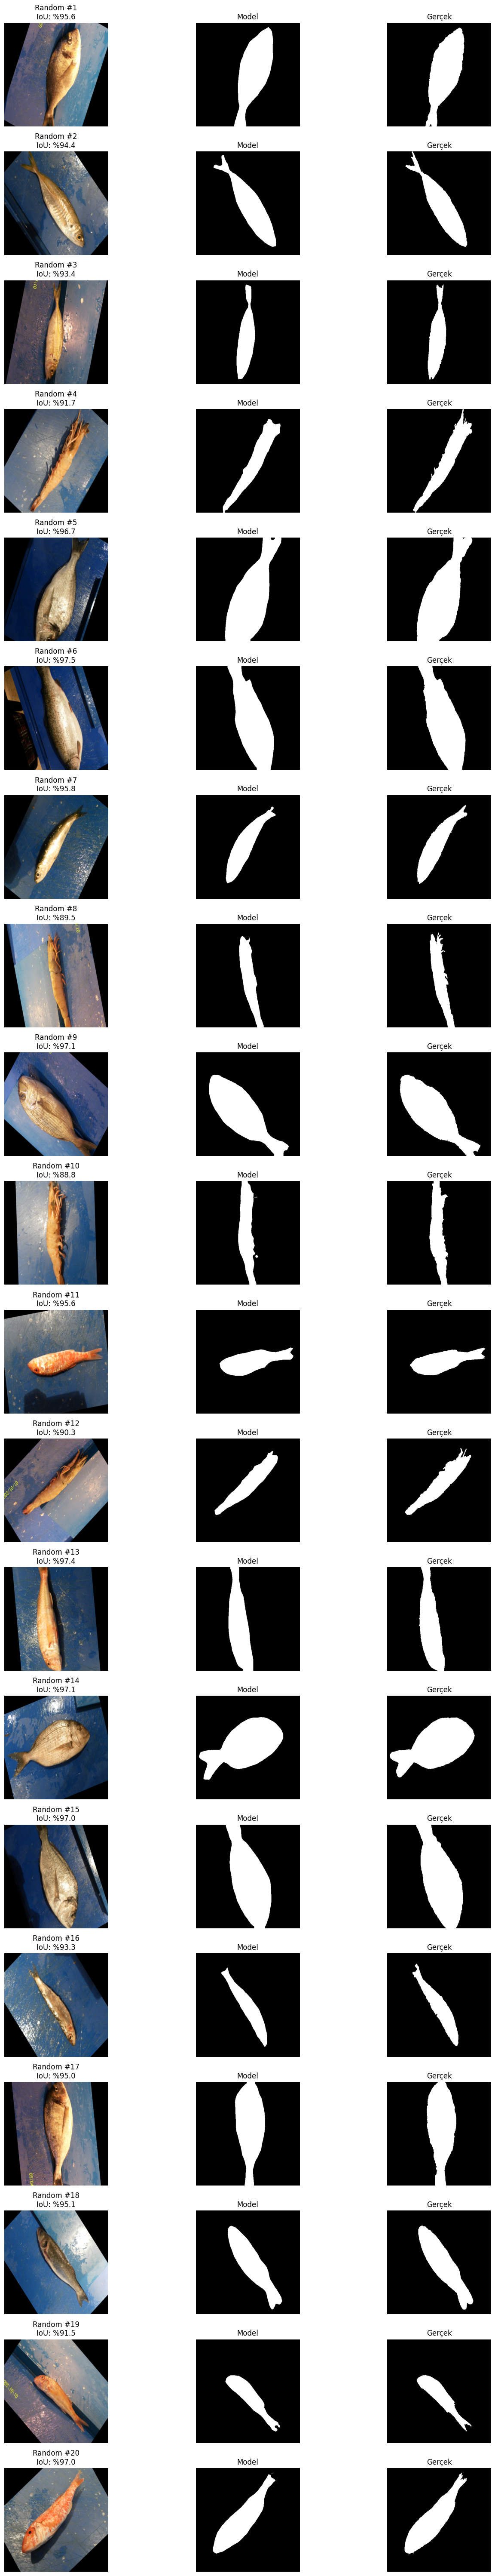


🏆 EN İYİ 5 SONUÇ


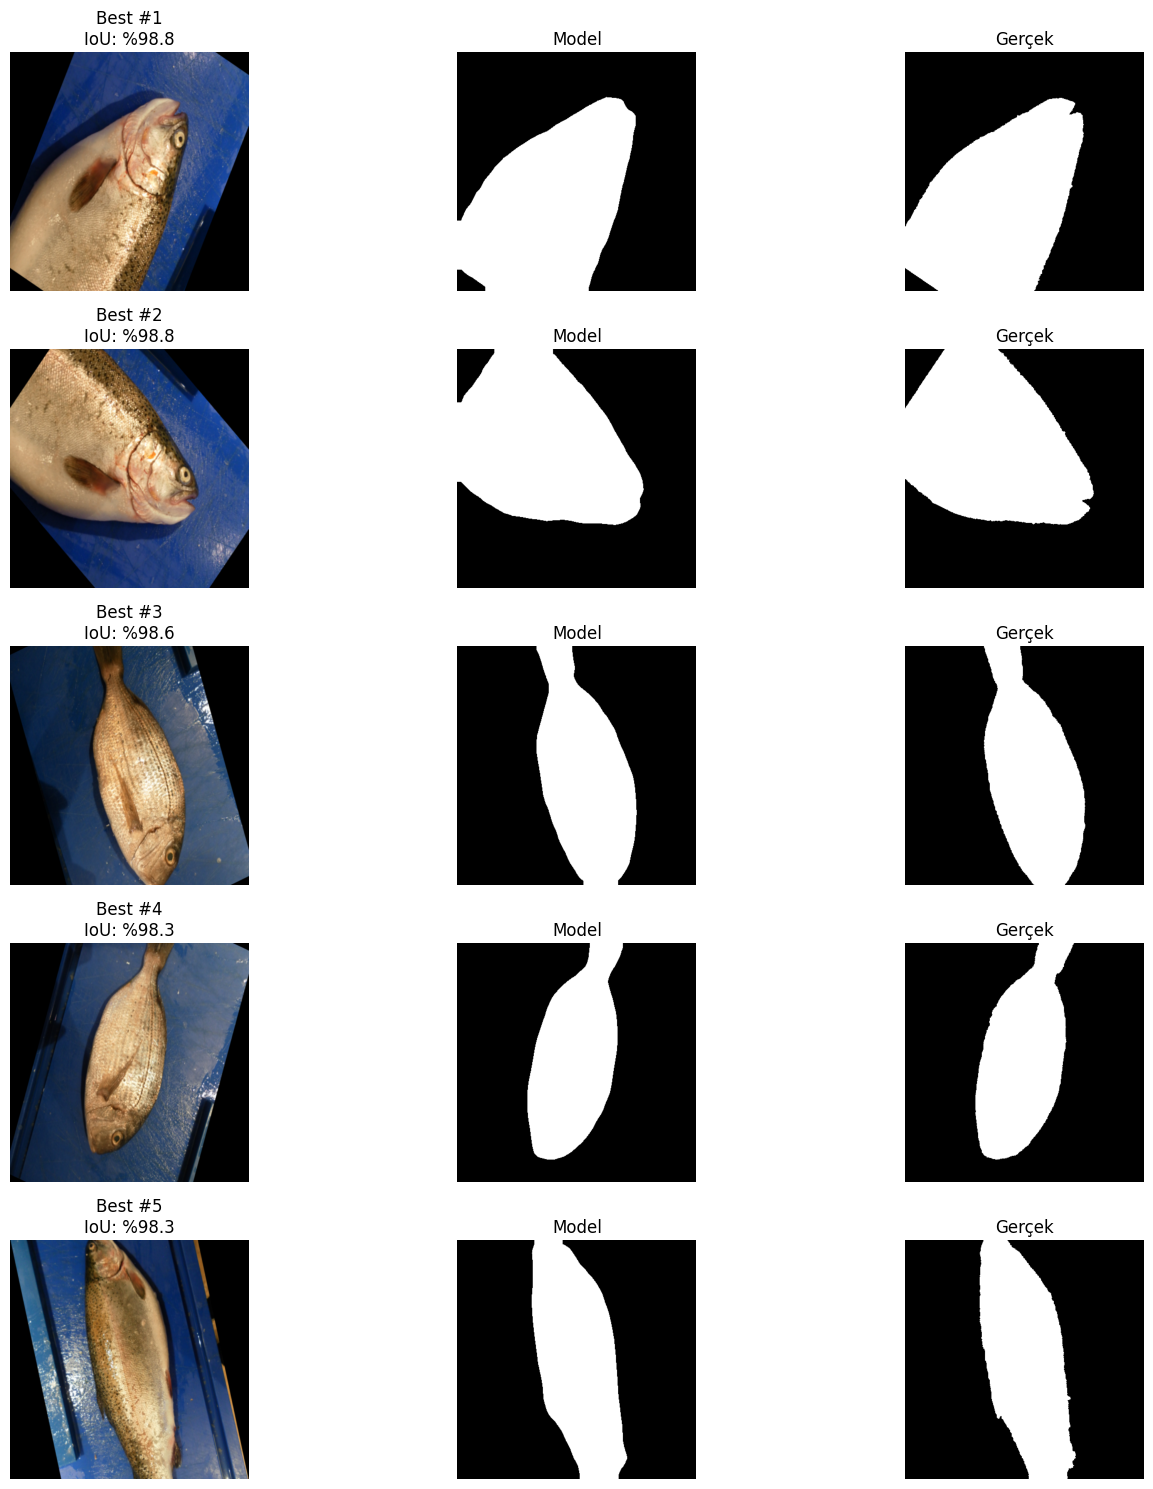


⚠️ EN KÖTÜ 5 SONUÇ


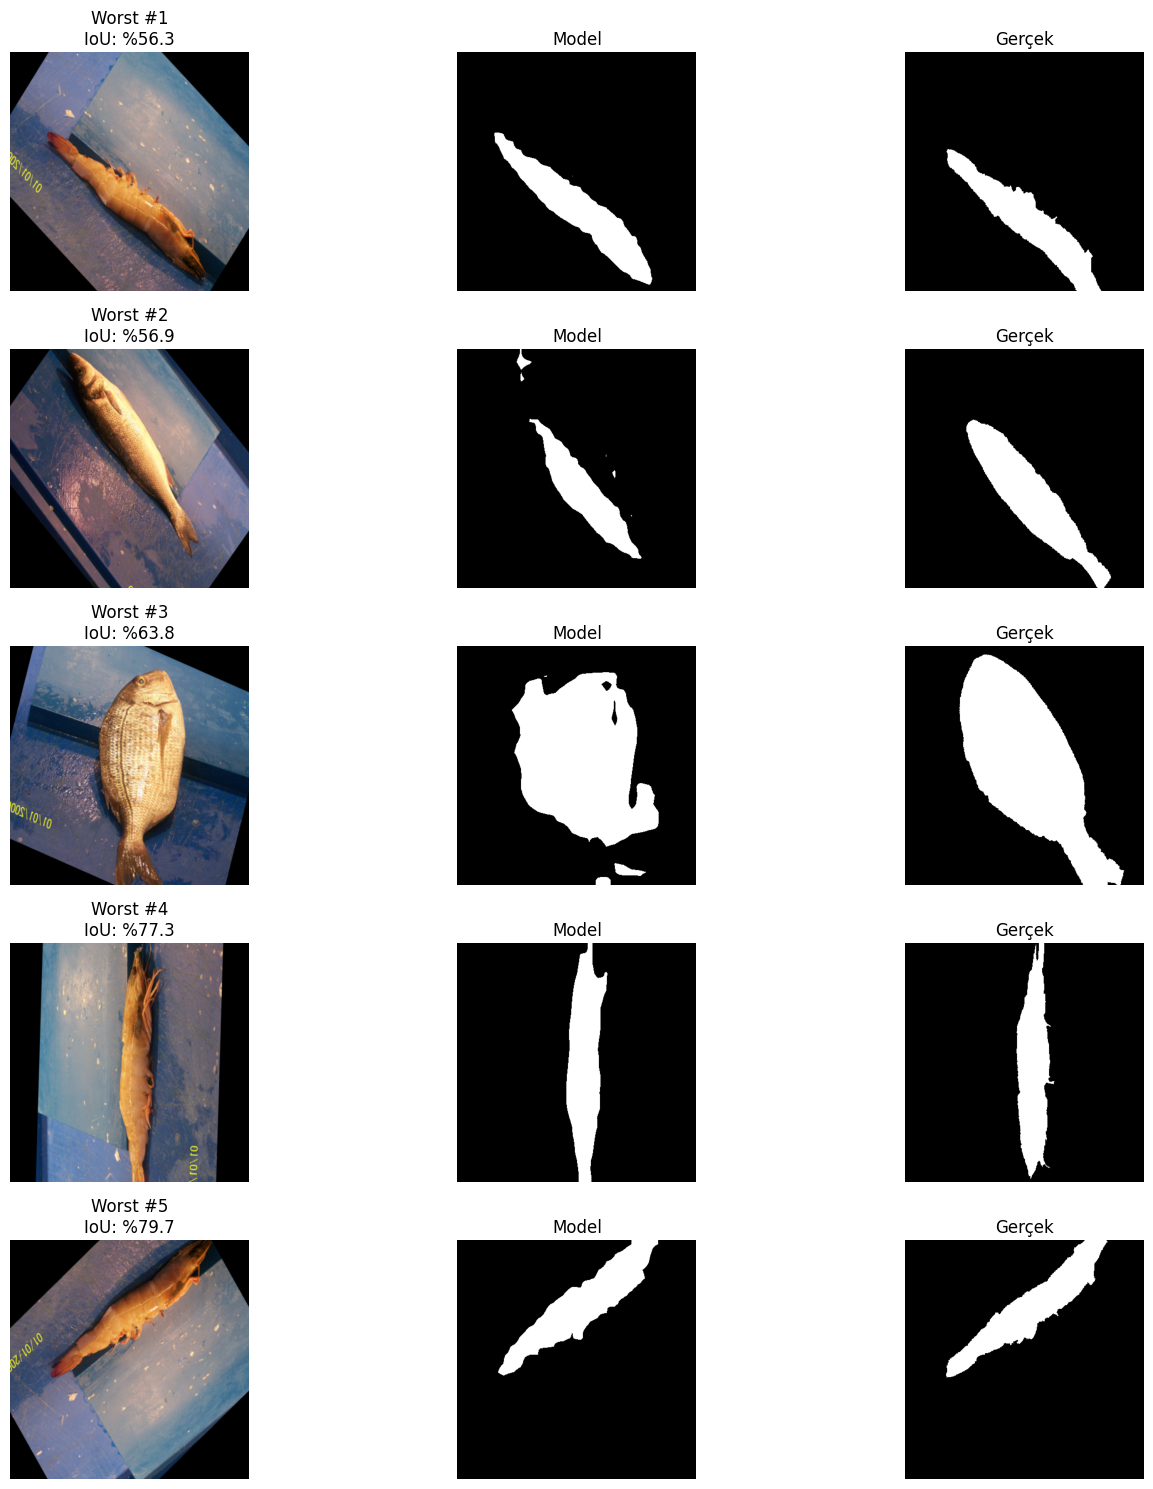

In [ ]:
# ========================================================
# DINOv3: FINAL FULL PIPELINE (GLOB + ADVANCED PLOTS)
# ========================================================


# 1. KURULUM
!pip install -q scikit-learn transformers accelerate timm kaggle torchvision matplotlib huggingface_hub opencv-python seaborn


import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from transformers import AutoModel
from PIL import Image
from google.colab import files, drive
from huggingface_hub import login
from glob import glob
import random


# --------------------------------------------------------
# 2. AYARLAR VE SEED SABİTLEME (AYNI BALIKLAR İÇİN)
# --------------------------------------------------------
drive.mount('/content/drive')


def set_seed(seed=42):
   """Arkadaşınla aynı rastgeleliği yakalamak için"""
   random.seed(seed)
   os.environ['PYTHONHASHSEED'] = str(seed)
   np.random.seed(seed)
   torch.manual_seed(seed)
   torch.cuda.manual_seed(seed)
   torch.backends.cudnn.deterministic = True
   print(f"🌱 Seed sabitlendi: {seed}")


set_seed(42) # İkiniz de 42 kullanırsanız aynı balıklar gelir.


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Cihaz: {device}")


HF_TOKEN = "--"
MODEL_ID = "facebook/dinov3-vits16-pretrain-lvd1689m"
SAVE_DIR = "/content/drive/MyDrive/Fish_Project"
MODEL_NAME = "dinov3_fish_segmentation_final.pth"
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
os.makedirs(SAVE_DIR, exist_ok=True)


# --------------------------------------------------------
# 3. VERİ SETİ (GLOB YÖNTEMİ İLE)
# --------------------------------------------------------
def setup_dataset():
   if not os.path.exists("fish_dataset"):
       print("\n📂 Veri seti indiriliyor...")
       if not os.path.exists("kaggle.json"):
           print("⚠️ Lütfen 'kaggle.json' dosyasını yükleyiniz...")
           files.upload()
       !mkdir -p ~/.kaggle
       !mv kaggle.json ~/.kaggle/ 2>/dev/null || true
       !chmod 600 ~/.kaggle/kaggle.json
       !kaggle datasets download -d crowww/a-large-scale-fish-dataset
       !unzip -q a-large-scale-fish-dataset.zip -d fish_dataset
       print("✅ İndirme tamamlandı.")


setup_dataset()


class FishGlobDataset(Dataset):
   def __init__(self, root_dir="fish_dataset/Fish_Dataset/Fish_Dataset", img_size=448):
       self.img_size = img_size

       # --- ARKADAŞININ KULLANDIĞI GLOB MANTIĞI ---
       # Tüm PNG dosyalarını bul
       all_files = glob(os.path.join(root_dir, "*", "*", "*.png"))

       # Sadece GT (Maske) olanları ayır
       self.mask_files = sorted(glob(os.path.join(root_dir, "*", "* GT", "*.png")))

       # GT olmayanlar resimdir (Küme farkı işlemi)
       all_set = set(all_files)
       mask_set = set(self.mask_files)
       self.img_files = sorted(list(all_set - mask_set))

       # Kontrol
       # Bazı dosya isimleri uyumsuz olabilir, garantiye almak için pair yapalım
       # Klasör yapısı: Class/Class/Name.png ve Class/Class GT/Name.png
       # Biz burada basitçe sıralı listeleri eşleştireceğiz (dosya sayıları eşitse)

       print(f"🖼️ Images: {len(self.img_files)}, 🎭 Masks: {len(self.mask_files)}")

       # Transformlar
       self.transform_img = T.Compose([
           T.Resize((img_size, img_size)),
           T.ToTensor(),
           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       ])
       self.transform_mask = T.Compose([
           T.Resize((img_size, img_size), interpolation=Image.NEAREST),
           T.ToTensor()
       ])


   def __len__(self): return len(self.img_files)


   def __getitem__(self, idx):
       # Burada dosya isimlerinin eşleştiğini varsayıyoruz (sorted yaptığımız için)
       img_path = self.img_files[idx]

       # Maske yolunu dinamik bulmak daha güvenli (GT klasöründen)
       # Örnek: .../Red Sea Bream/Red Sea Bream/001.png
       # Hedef: .../Red Sea Bream/Red Sea Bream GT/001.png
       parent = os.path.dirname(img_path) # .../Red Sea Bream/Red Sea Bream
       filename = os.path.basename(img_path) # 001.png
       grandparent = os.path.dirname(parent) # .../Red Sea Bream
       class_name = os.path.basename(parent) # Red Sea Bream

       mask_path = os.path.join(grandparent, f"{class_name} GT", filename)

       # Eğer bu dinamik yol yoksa, sorted listesinden al (Fallback)
       if not os.path.exists(mask_path):
            mask_path = self.mask_files[idx]


       return self.transform_img(Image.open(img_path).convert("RGB")), \
              self.transform_mask(Image.open(mask_path).convert("L"))


# Veri Yükleme
full_ds = FishGlobDataset()
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size


# Generator seed ile sabitlenmiş split
generator = torch.Generator().manual_seed(42)
train_ds, test_ds = random_split(full_ds, [train_size, test_size], generator=generator)


BATCH_SIZE = 8
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # Train shuffle olabilir
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False) # Test sabit kalsın


# --------------------------------------------------------
# 4. MODEL
# --------------------------------------------------------
class DINOv3SegmentationModel(nn.Module):
   def __init__(self, dino_model_id, hf_token):
       super().__init__()
       login(token=hf_token)
       self.backbone = AutoModel.from_pretrained(dino_model_id, token=hf_token)
       for param in self.backbone.parameters(): param.requires_grad = False
       self.backbone.eval()
       self.num_registers = getattr(self.backbone.config, "num_register_tokens", 0)
       self.embed_dim = self.backbone.config.hidden_size
       self.decoder = nn.Sequential(
           nn.Conv2d(self.embed_dim, 128, kernel_size=3, padding=1),
           nn.BatchNorm2d(128), nn.ReLU(),
           nn.Conv2d(128, 64, kernel_size=3, padding=1),
           nn.BatchNorm2d(64), nn.ReLU(),
           nn.Conv2d(64, 1, kernel_size=1)
       )
   def forward(self, x):
       B, C, H, W = x.shape
       with torch.no_grad():
           outputs = self.backbone(pixel_values=x)
           patch_tokens = outputs.last_hidden_state[:, (1 + self.num_registers):, :]
       N = patch_tokens.shape[1]; grid_size = int(N**0.5)
       features = patch_tokens.permute(0, 2, 1).reshape(B, self.embed_dim, grid_size, grid_size)
       return F.interpolate(self.decoder(features), size=(H, W), mode="bilinear", align_corners=False)


# --------------------------------------------------------
# 5. EĞİTİM VE TEST FONKSİYONLARI (DETAYLI LİSTE DÖNEN)
# --------------------------------------------------------
def calculate_iou_batch(preds, labels):
   preds_bin = (torch.sigmoid(preds) > 0.5).float()
   intersection = (preds_bin * labels).sum()
   union = preds_bin.sum() + labels.sum() - intersection
   return (intersection + 1e-6) / (union + 1e-6)


def run_epoch(model, loader, optimizer, criterion, is_train=True):
   if is_train: model.decoder.train()
   else: model.decoder.eval()

   losses = []
   ious = []

   with torch.set_grad_enabled(is_train):
       for images, masks in loader:
           images, masks = images.to(device), masks.to(device)
           if is_train: optimizer.zero_grad()

           outputs = model(images)
           loss = criterion(outputs, masks)

           if is_train:
               loss.backward()
               optimizer.step()

           losses.append(loss.item())
           ious.append(calculate_iou_batch(outputs, masks).item())

   return losses, ious


# --------------------------------------------------------
# 6. GRAFİK ÇİZİM FONKSİYONLARI (İSTEDİĞİNİZ TİPTE)
# --------------------------------------------------------
def save_advanced_plots(train_data, val_data):
   """
   train_data: {'losses': [list of lists], 'ious': [list of lists]}
   val_data:   {'losses': [list of lists], 'ious': [list of lists]}
   """
   # Verileri düzleştir (Iteration grafikleri için)
   train_iter_loss = [item for sublist in train_data['losses'] for item in sublist]
   train_iter_iou = [item for sublist in train_data['ious'] for item in sublist]
   val_iter_loss = [item for sublist in val_data['losses'] for item in sublist]
   val_iter_iou = [item for sublist in val_data['ious'] for item in sublist]


   # Epoch İstatistikleri (Mean ± Std grafikleri için)
   epochs = range(1, len(train_data['losses']) + 1)

   t_loss_mean = [np.mean(x) for x in train_data['losses']]
   t_loss_std = [np.std(x) for x in train_data['losses']]
   v_loss_mean = [np.mean(x) for x in val_data['losses']]
   v_loss_std = [np.std(x) for x in val_data['losses']]

   t_iou_mean = [np.mean(x) for x in train_data['ious']]
   t_iou_std = [np.std(x) for x in train_data['ious']]
   v_iou_mean = [np.mean(x) for x in val_data['ious']]
   v_iou_std = [np.std(x) for x in val_data['ious']]


   # --- 1. Train Iteration Loss ---     plt.figure(figsize=(12, 6))
   plt.plot(train_iter_loss, label='Train Iteration Loss', linewidth=1)
   plt.title('Train Iteration Loss', fontsize=16, fontweight='bold')
   plt.xlabel('Step', fontsize=12); plt.ylabel('Loss Value', fontsize=12)
   plt.grid(True, alpha=0.3); plt.legend(); plt.savefig(os.path.join(SAVE_DIR, "1_Train_Iteration_Loss.png"))
   plt.close()


   # --- 2. Train Iteration IoU ---     plt.figure(figsize=(12, 6))
   plt.plot(train_iter_iou, label='Train Iteration IoU', linewidth=1)
   plt.title('Train Iteration IoU', fontsize=16, fontweight='bold')
   plt.xlabel('Step', fontsize=12); plt.ylabel('IoU Value', fontsize=12)
   plt.grid(True, alpha=0.3); plt.legend(); plt.savefig(os.path.join(SAVE_DIR, "2_Train_Iteration_IoU.png"))
   plt.close()


   # --- 3. Train vs Val Loss (Mean ± Std) ---     plt.figure(figsize=(12, 6))
   plt.plot(epochs, t_loss_mean, 'o-', label='Train Loss', color='tab:blue')
   plt.fill_between(epochs, np.array(t_loss_mean)-np.array(t_loss_std), np.array(t_loss_mean)+np.array(t_loss_std), alpha=0.2, color='tab:blue', label='Train Loss ± Std')
   plt.plot(epochs, v_loss_mean, 'o-', label='Val Loss', color='tab:orange')
   plt.fill_between(epochs, np.array(v_loss_mean)-np.array(v_loss_std), np.array(v_loss_mean)+np.array(v_loss_std), alpha=0.2, color='tab:orange', label='Val Loss ± Std')
   plt.title('Train vs Validation Loss (Mean ± Std)', fontsize=16, fontweight='bold')
   plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True, alpha=0.3); plt.legend()
   plt.savefig(os.path.join(SAVE_DIR, "3_Train_Val_Loss_MeanStd.png")); plt.close()


   # --- 4. Val Iteration Loss ---     plt.figure(figsize=(12, 6))
   plt.plot(val_iter_loss, label='Val Iteration Loss', color='tab:orange', linewidth=1)
   plt.title('Val Iteration Loss', fontsize=16, fontweight='bold')
   plt.xlabel('Step'); plt.ylabel('Loss Value'); plt.grid(True, alpha=0.3); plt.legend()
   plt.savefig(os.path.join(SAVE_DIR, "4_Val_Iteration_Loss.png")); plt.close()


   # --- 5. Train vs Val IoU (Mean ± Std) ---     plt.figure(figsize=(12, 6))
   plt.plot(epochs, t_iou_mean, 'o-', label='Train IoU', color='tab:blue')
   plt.fill_between(epochs, np.array(t_iou_mean)-np.array(t_iou_std), np.array(t_iou_mean)+np.array(t_iou_std), alpha=0.2, color='tab:blue', label='Train IoU ± Std')
   plt.plot(epochs, v_iou_mean, 'o-', label='Val IoU', color='tab:orange')
   plt.fill_between(epochs, np.array(v_iou_mean)-np.array(v_iou_std), np.array(v_iou_mean)+np.array(v_iou_std), alpha=0.2, color='tab:orange', label='Val IoU ± Std')
   plt.title('Train vs Validation IoU (Mean ± Std)', fontsize=16, fontweight='bold')
   plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.grid(True, alpha=0.3); plt.legend()
   plt.savefig(os.path.join(SAVE_DIR, "5_Train_Val_IoU_MeanStd.png")); plt.close()


   # --- 6. Val Iteration IoU ---     plt.figure(figsize=(12, 6))
   plt.plot(val_iter_iou, label='Val Iteration IoU', color='tab:orange', linewidth=1)
   plt.title('Val Iteration IoU', fontsize=16, fontweight='bold')
   plt.xlabel('Step'); plt.ylabel('IoU Value'); plt.grid(True, alpha=0.3); plt.legend()
   plt.savefig(os.path.join(SAVE_DIR, "6_Val_Iteration_IoU.png")); plt.close()

   print("📈 Tüm grafikler Drive'a kaydedildi!")


def show_results(model, loader):
   print("\n🔎 SONUÇLAR GÖSTERİLİYOR (Aynı Seed ile)...")
   model.eval()
   all_res = []

   # Tüm test setinden örnekler topla
   with torch.no_grad():
       for i, (images, masks) in enumerate(loader):
           images, masks = images.to(device), masks.to(device)
           outputs = model(images)
           preds = (torch.sigmoid(outputs) > 0.5).float()

           for k in range(images.size(0)):
               inter = (preds[k] * masks[k]).sum().item()
               union = preds[k].sum().item() + masks[k].sum().item() - inter
               iou = (inter + 1e-6) / (union + 1e-6)
               all_res.append({'img': images[k].cpu(), 'gt': masks[k].cpu(), 'pred': preds[k].cpu(), 'iou': iou})

           if len(all_res) > 300: break # Çok uzamasın diye kes


   # Seed sabit olduğu için shuffle yapsak bile aynı sırayla karışır
   random.shuffle(all_res)

   # Sıralamalar
   sorted_res = sorted(all_res, key=lambda x: x['iou'])
   worst_5 = sorted_res[:5]
   best_5 = sorted_res[-5:]; best_5.reverse()
   random_20 = all_res[:20]


   def plot_list(lst, title):
       plt.figure(figsize=(15, 3 * len(lst)))
       for idx, item in enumerate(lst):
           img = item['img'].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
           img = np.clip(img, 0, 1)
           plt.subplot(len(lst), 3, idx*3+1); plt.imshow(img); plt.title(f"{title} #{idx+1}\nIoU: %{item['iou']*100:.1f}"); plt.axis('off')
           plt.subplot(len(lst), 3, idx*3+2); plt.imshow(item['pred'][0], cmap='gray'); plt.title("Model"); plt.axis('off')
           plt.subplot(len(lst), 3, idx*3+3); plt.imshow(item['gt'][0], cmap='gray'); plt.title("Gerçek"); plt.axis('off')
       plt.tight_layout(); plt.show()


   print("\n🎲 20 RASTGELE SONUÇ"); plot_list(random_20, "Random")
   print("\n🏆 EN İYİ 5 SONUÇ"); plot_list(best_5, "Best")
   print("\n⚠️ EN KÖTÜ 5 SONUÇ"); plot_list(worst_5, "Worst")


# --------------------------------------------------------
# 7. ANA ÇALIŞTIRMA (MAIN)
# --------------------------------------------------------
model = DINOv3SegmentationModel(MODEL_ID, HF_TOKEN).to(device)


if os.path.exists(MODEL_PATH):
   # SENARYO A: Model Var -> Sadece Sonuç Göster
   print(f"🎉 Model bulundu: {MODEL_PATH}")
   print("Grafikler çizilmeyecek (Çizmek istiyorsan Drive'dan modeli silip tekrar çalıştır).")
   model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
   show_results(model, test_dl)


else:
   # SENARYO B: Model Yok -> Eğit, Kaydet, Grafik Çiz, Sonuç Göster
   print("⚙️ Model bulunamadı. Eğitim başlıyor...")
   optimizer = optim.AdamW(model.decoder.parameters(), lr=1e-3)
   criterion = nn.BCEWithLogitsLoss()

   # Veri Saklama Kutuları
   train_history = {'losses': [], 'ious': []}
   val_history = {'losses': [], 'ious': []}

   EPOCHS = 20 # İsteğe bağlı artırabilirsin

   for epoch in range(EPOCHS):
       print(f"Epoch {epoch+1}/{EPOCHS} çalışıyor...")

       # Train
       t_losses, t_ious = run_epoch(model, train_dl, optimizer, criterion, is_train=True)
       train_history['losses'].append(t_losses)
       train_history['ious'].append(t_ious)

       # Val
       v_losses, v_ious = run_epoch(model, test_dl, optimizer, criterion, is_train=False)
       val_history['losses'].append(v_losses)
       val_history['ious'].append(v_ious)

       print(f"   -> Train Mean IoU: %{np.mean(t_ious)*100:.2f} | Val Mean IoU: %{np.mean(v_ious)*100:.2f}")


   # Kaydetme
   print(f"💾 Model kaydediliyor: {MODEL_PATH}")
   torch.save(model.state_dict(), MODEL_PATH)

   # Grafikleri Çiz ve Kaydet
   save_advanced_plots(train_history, val_history)

   # Sonuçları Göster
   show_results(model, test_dl)